In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  1. Import Librarie

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# 2. Download French Bank Pair Data

In [3]:
tickers = ["BNP.PA", "GLE.PA"]

data = yf.download(tickers, start="2010-01-01", end="2025-12-31")["Close"]
data = data.dropna()

S1 = data["BNP.PA"]
S2 = data["GLE.PA"]

/tmp/ipykernel_55/1465741841.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2010-01-01", end="2025-12-31")["Close"]
[*********************100%***********************]  2 of 2 completed


# 3. Cointegration Test (Engle-Granger)

In [4]:
score, pvalue, _ = coint(S1, S2)
print("Cointegration p-value:", pvalue)

Cointegration p-value: 0.7074854734080188


If p-value < 0.05 → pair is cointegrated

# 4. Estimate Hedge Ratio (OLS)

In [5]:
S2_const = sm.add_constant(S2)
model = OLS(S1, S2_const).fit()

hedge_ratio = model.params[1]
print("Hedge Ratio:", hedge_ratio)

Hedge Ratio: 1.1680816365389217


/tmp/ipykernel_55/1062232385.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


# 5. Construct Spread

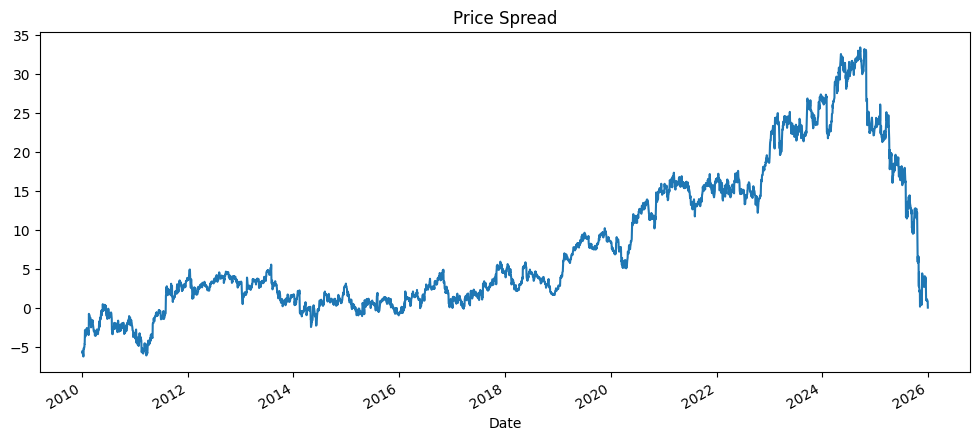

In [7]:
spread = S1 - hedge_ratio * S2
spread.plot(figsize=(12,5))
plt.title("Price Spread")
plt.show()

# 6. Z-Score Signal Engine

In [8]:
spread_mean = spread.rolling(60).mean()
spread_std = spread.rolling(60).std()

zscore = (spread - spread_mean) / spread_std

# 7. Trading Signals

Rules:

Z > 2 → Short Spread

Z < -2 → Long Spread

Exit when Z near 0

In [9]:
signals = pd.Series(0, index=zscore.index)

signals[zscore > 2] = -1
signals[zscore < -2] = 1
signals[np.abs(zscore) < 0.5] = 0

# 8. Compute Strategy Returns

In [10]:
returns = data.pct_change().dropna()

strategy_returns = signals.shift(1) * (
    returns["BNP.PA"] - hedge_ratio * returns["GLE.PA"]
)

strategy_returns = strategy_returns.dropna()

# 9. Add Transaction Cost (10 bps)

In [11]:
turnover = signals.diff().abs()
transaction_cost = turnover * 0.001

net_returns = strategy_returns - transaction_cost

# 10. Performance Metrics

In [12]:
def performance_metrics(returns):
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    cumulative = (1 + returns).cumprod()
    max_dd = (cumulative / cumulative.cummax() - 1).min()
    return ann_return, ann_vol, sharpe, max_dd

metrics = performance_metrics(net_returns)
metrics

(np.float64(0.039532647960364334),
 np.float64(0.10433203253638755),
 np.float64(0.37891189310988127),
 -0.2102300305397723)

# 11. Equity Curve

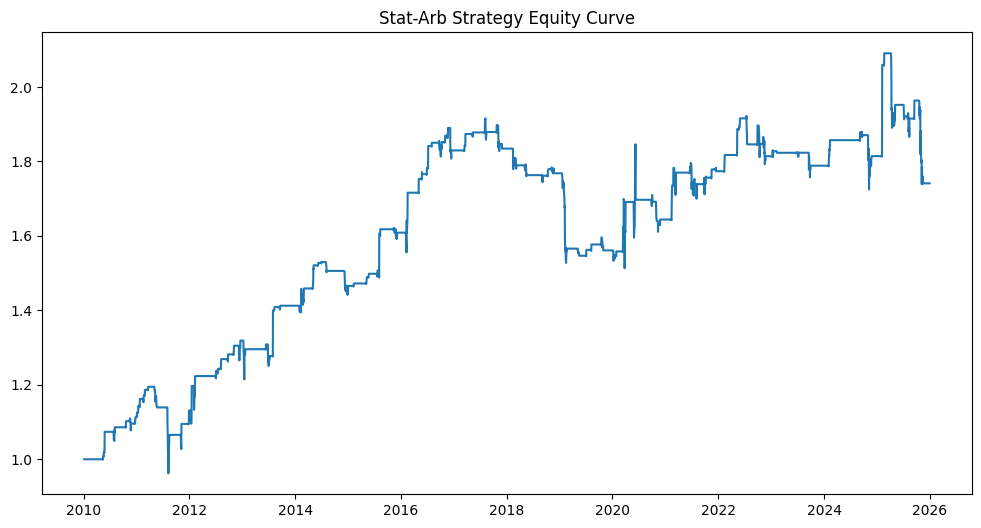

In [13]:
plt.figure(figsize=(12,6))
plt.plot((1+net_returns).cumprod())
plt.title("Stat-Arb Strategy Equity Curve")
plt.show()